# FSI TimeMarching test

In [4]:
include("../src/FSI.jl")
using FSI

In [2]:
using Revise
using Plots
pyplot()
clibrary(:colorbrewer)
default(grid = false)

In [3]:
filename = "FSI";

## <span style="color:blue"> Set up rigid body with Dyn3d

#### Include any joint-body setup script from Dyn3d

In [111]:
# include(Pkg.dir("Dyn3d")*"/src/config_files/2dFall.jl")

# problem dimension
ndim = 2
# numerical params
tf = 6
dt = 1e-3
scheme = "Liska"
st = 3
tol = 1e-4
num_params = NumParams(tf, dt, scheme, st, tol)
# gravity
gravity = [0., -1.0, 0.]

# set up system config info
config_system = ConfigSystem(ndim, gravity, num_params)

# set up bodys
nbody = 1
config_body = ConfigBody(nbody, 4,
   [0. 0.; 1. 0.; 1. 1./nbody; 0. 1./nbody], 1.0)
config_bodys = fill(config_body, nbody)

# set up joints
njoint = nbody

config_joints = Vector{ConfigJoint}(njoint)

# set the first passive joint with no stiff and damp
dof_1 = Dof(5, "passive", 0., 0., Motions())

config_joints[1] = ConfigJoint(njoint, "custom",
    [0.,0.,0.,0.5,0.5,0.], zeros(Float64,6), 0, [dof_1], [0.])

 joint type = custom
 joint position in parent body coord = [0.0, 0.0, 0.0, 0.5, 0.5, 0.0]
 joint position in child body coord = [0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
 joint unconstrained dof = 5, under passive motion
 initial unconstrained dof position = [0.0]


#### Build joint-body chain

In [112]:
bs, js, bsys = BuildChain(config_bodys, config_joints, config_system)
bd = BodyDyn(bs, js, bsys)

#### Initialize rigid body system state to complete body-joint information

In [113]:
bd, soln₀ = InitSystem!(bd)

This is a 1 body-joint system, system is fixed in space

(, Dyn3d.ConstructSystem.Soln{Float64}(0.0, 0.001, [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.0, 0.0, 0.0, 0.0, 0.0, 0.0], Float64[], Float64[]))

#### Initialize u and λ container

In [114]:
qJ = soln₀.qJ
v = soln₀.v
λ_dim = bd.sys.ncdof_HERK
λ = zeros(Float64,λ_dim);

This is a 1 body-joint system, system is fixed in space

#### Get body verts for plotting

In [115]:
@get bd (bs, js, sys)
bs, js, sys = UpdatePosition!(bs, js, sys, soln₀.qJ)
vs₀ = VertsHistory(sys.nbody, bs);

#### Plot body only

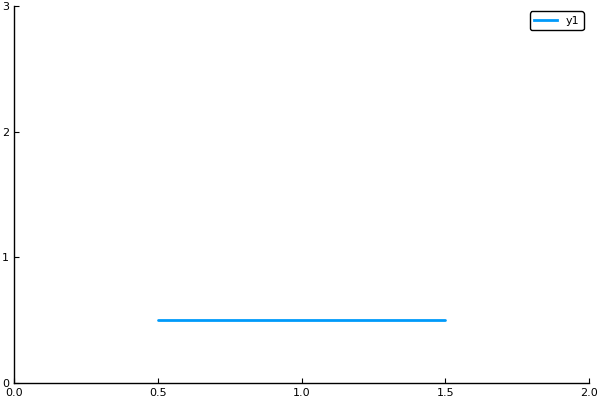

In [116]:
p = plot()
for i = 1:sys.nbody
    plot!(p,vs₀[i,2:3,1], vs₀[i,2:3,2],linewidth=2)
end
plot!(xlims=(0,2), ylims=(0,3))

## <span style="color:blue"> Set up fluid with Whirl </span>

#### Set the flow parameters

In [117]:
Re = 200 # Reynolds number
U = 1.0 # Free stream velocity
U∞ = (0.0, U)
U∞ = (U, 0.0)

(0.0, 1.0)

#### Set the domain grid

In [118]:
nx = 102; ny = 152;
Ly = 3.0;
Δx = Ly/(ny-2);
Δt = min(0.5*Δx,0.5*Δx^2*Re)
w₀ = Nodes(Dual,(nx,ny))
xg, yg = coordinates(w₀,dx=Δx)

(-0.01:0.02:2.0100000000000002, -0.01:0.02:3.0100000000000002)

#### Set up fluid initial conditions

In [119]:
w₀ .= 0.0;
w = deepcopy(w₀);

## <span style="color:blue"> Create fluid-body interface </span>

#### Genrate body grid points and get linear velocity on them

In [120]:
# bgs short for body grid system
bgs = GenerateBodyGrid(bd; np=DetermineNP(nbody, Δx))
bgs = CutOut2d(bd,bgs);

#### Get body points initial coordinates for fluids

In [121]:
bgs = AcquireBodyGridKinematics(bd,bgs)
coord_init = hcat(bgs[1].q_i...)'[:,[1,2]]
for i = 2:length(bgs)
    coord_init = [coord_init[1:end-1,:]; hcat(bgs[i].q_i...)'[:,[1,2]]]
end

#### Set up body grid points and force container in fluid

In [122]:
X̃ = VectorData(coord_init)
f = VectorData(X̃);

#### Create fluidstruct structure

In [123]:
tf = 200Δt
T = Δt:Δt:tf
fsys = FluidStruct((nx,ny),Re,Δx,Δt,U∞ = U∞, X̃ = X̃, rk=RK31)
N = length(X̃)÷2

51

## <span style="color:blue"> Create ifherk object </span>

In [124]:
@time ifherk_coupled = FSI.IFHERK_coupled(fsys.Δt,bd,bgs,(w₀,qJ,v,f,λ),
                ((t,u) -> Systems.plan_intfact(t,u,fsys), B₁ᵀ, B₂),
                (M⁻¹, G₁ᵀ, G₂, UpP, UpV),
                ((bd,bgs,f) -> T₁ᵀ(bd,bgs,f,fsys.Δx), T₂, getX̃),
                ((w,t) -> r₁(w,t,fsys), F, w -> U_inf(w,fsys), gti),
                fsys, tol=1e-3,rk=Whirl.TimeMarching.RK31)

 13.320535 seconds (88.70 M allocations: 16.175 GiB, 23.19% gc time)


Stage-3+ IF-HERK integrator with
   Time step size 0.01


In [125]:
fx = Float64[]
fy = Float64[]
thist = []
whist = []
bdhist = BodyDyn[];

## <span style="color:blue"> TimeMarching! </span>

In [126]:
@time for t in T
    
    @time t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
#     t, (w, f), (qJ, v, λ), bd = ifherk_coupled(t, w, qJ, v, bd,fsys)
    
    push!(thist,t)
    push!(fx,sum(f.u)*Δx^2)
    push!(fy,sum(f.v)*Δx^2)
    push!(whist,deepcopy(w))
    push!(bdhist,deepcopy(bd))
    println("next time unit is ",t)
end

 12.466644 seconds (88.81 M allocations: 16.174 GiB, 22.37% gc time)
next time unit is 0.02
 11.483828 seconds (88.55 M allocations: 16.164 GiB, 24.12% gc time)
next time unit is 0.03
 11.576572 seconds (88.55 M allocations: 16.164 GiB, 24.03% gc time)
next time unit is 0.04
 11.600974 seconds (88.55 M allocations: 16.164 GiB, 24.88% gc time)
next time unit is 0.05
 11.419092 seconds (88.55 M allocations: 16.164 GiB, 23.88% gc time)
next time unit is 0.060000000000000005
 11.821202 seconds (88.55 M allocations: 16.164 GiB, 23.87% gc time)
next time unit is 0.06999999999999999
 12.425989 seconds (88.55 M allocations: 16.164 GiB, 23.13% gc time)
next time unit is 0.08
 11.588708 seconds (88.55 M allocations: 16.164 GiB, 24.03% gc time)
next time unit is 0.09
 11.209719 seconds (88.55 M allocations: 16.164 GiB, 22.80% gc time)
next time unit is 0.09999999999999999
 11.180626 seconds (88.55 M allocations: 16.164 GiB, 22.74% gc time)
next time unit is 0.11
 11.444463 seconds (88.55 M alloca

 11.360213 seconds (88.55 M allocations: 16.164 GiB, 23.85% gc time)
next time unit is 0.89
 11.243371 seconds (88.55 M allocations: 16.164 GiB, 22.76% gc time)
next time unit is 0.9
 11.120831 seconds (88.55 M allocations: 16.164 GiB, 22.56% gc time)
next time unit is 0.91
 11.265502 seconds (88.55 M allocations: 16.164 GiB, 23.63% gc time)
next time unit is 0.92
 11.176584 seconds (88.55 M allocations: 16.164 GiB, 22.71% gc time)
next time unit is 0.93
 11.216295 seconds (88.55 M allocations: 16.164 GiB, 22.80% gc time)
next time unit is 0.9400000000000001
 11.269545 seconds (88.55 M allocations: 16.164 GiB, 22.92% gc time)
next time unit is 0.95
 11.319867 seconds (88.55 M allocations: 16.164 GiB, 23.72% gc time)
next time unit is 0.96
 11.046534 seconds (88.55 M allocations: 16.164 GiB, 22.41% gc time)
next time unit is 0.97
 11.174776 seconds (88.55 M allocations: 16.164 GiB, 22.41% gc time)
next time unit is 0.98
 11.065130 seconds (88.55 M allocations: 16.164 GiB, 22.55% gc time

 11.246693 seconds (88.55 M allocations: 16.164 GiB, 22.98% gc time)
next time unit is 1.78
 11.262553 seconds (88.55 M allocations: 16.164 GiB, 22.71% gc time)
next time unit is 1.79
 11.221262 seconds (88.55 M allocations: 16.164 GiB, 23.60% gc time)
next time unit is 1.8
 11.246495 seconds (88.55 M allocations: 16.164 GiB, 22.92% gc time)
next time unit is 1.81
 11.319691 seconds (88.55 M allocations: 16.164 GiB, 22.90% gc time)
next time unit is 1.82
 11.467674 seconds (88.55 M allocations: 16.164 GiB, 24.07% gc time)
next time unit is 1.83
 11.017392 seconds (88.55 M allocations: 16.164 GiB, 22.49% gc time)
next time unit is 1.84
 11.055899 seconds (88.55 M allocations: 16.164 GiB, 22.65% gc time)
next time unit is 1.85
 11.088040 seconds (88.55 M allocations: 16.164 GiB, 22.75% gc time)
next time unit is 1.86
 11.326810 seconds (88.55 M allocations: 16.164 GiB, 23.96% gc time)
next time unit is 1.87
 11.227250 seconds (88.55 M allocations: 16.164 GiB, 22.85% gc time)
next time un

## <span style="color:blue"> Plot </span>

#### Set contour levels and fps

In [11]:
contour_levels = linspace(-0.2,0.2,50)
sample_freq = 2
fps = 25;

#### Get body verts history

In [127]:
# get verts info based on this regular grid solution
vshist = []
for i = 1:length(bdhist)
    @get bdhist[i] (bs, js, sys)
    push!(vshist, VertsHistory(sys.nbody, bs))
end

#### Plot first and last time field

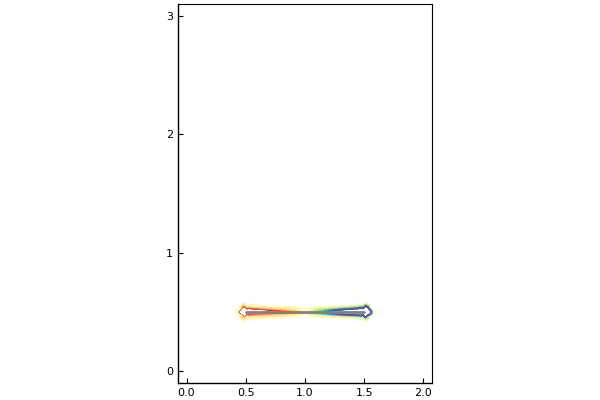

In [136]:
p = plot(xg,yg,whist[1],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="black")
end
p


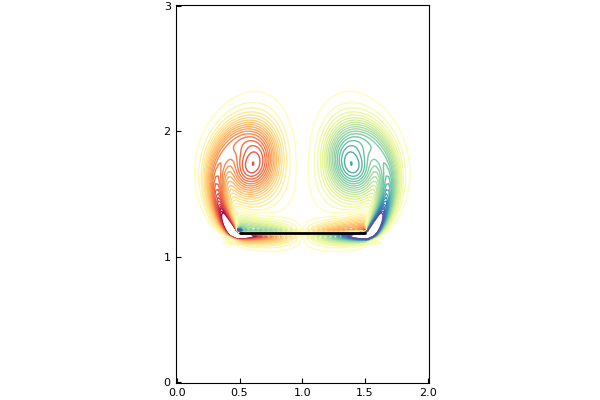

In [8]:
p = plot(xg,yg,whist[end],levels=contour_levels)
for i = 1:bd.sys.nbody
    plot!(p,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="black")
end
savefig(p,"plate.eps")
p

#### Body position begining and end

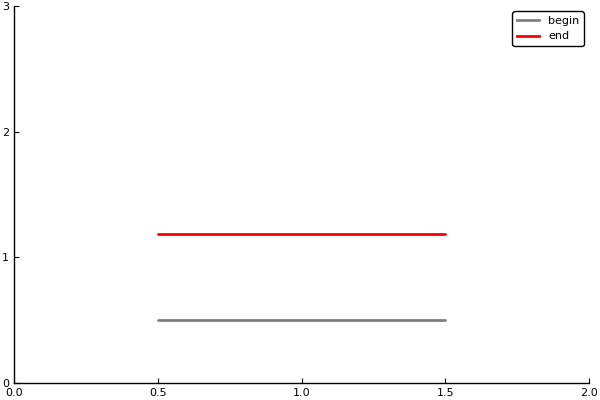

In [130]:
pb = plot()
for i = 1:sys.nbody
    plot!(pb,vshist[1][i,2:3,1], vshist[1][i,2:3,2],linewidth=2,linecolor="grey",label="begin")
end
for i = 1:sys.nbody
    plot!(pb,vshist[end][i,2:3,1], vshist[end][i,2:3,2],linewidth=2,linecolor="red",label="end")
end
plot!(pb,xlims=(xg[1],xg[end]), ylims=(yg[1],yg[end]))
pb

#### Make gif

In [12]:
anim = @animate for j = 1:length(whist)
    plot(xg,yg,whist[j],levels=contour_levels)
    for i = 1:sys.nbody
        plot!(vshist[j][i,2:3,1], vshist[j][i,2:3,2],linewidth=2,linecolor="black")
    end
end

gif(anim, filename*".gif", fps = fps)

INFO: Saved animation to /mnt/d/tmp/FSI.jl/examples/local_run/FSI.gif


Plots.AnimatedGif("/mnt/d/tmp/FSI.jl/examples/local_run/FSI.gif")

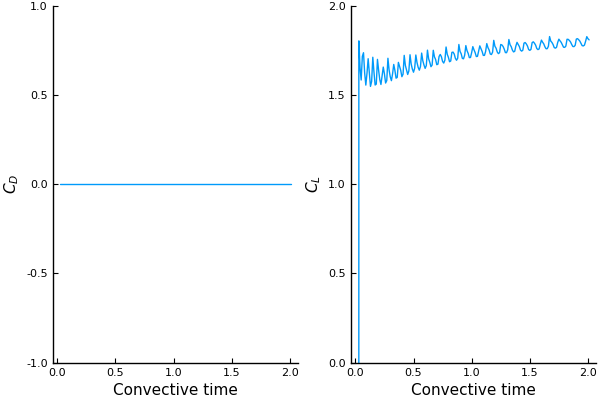

In [132]:
px = plot(thist,2*fx,ylim=(-1,1),xlabel="Convective time",ylabel="\$C_D\$",legend=false)
py = plot(thist,2*fy,ylim=(0,2),xlabel="Convective time",ylabel="\$C_L\$",legend=false)
plot(px,py)

## <span style="color:blue"> Save Data </span>

#### Save all current data related to plotting to a .jld file

In [133]:
using JLD
save(filename*".jld",
    "bd", bd,    
    "bdhist", bdhist,
    "xg", xg,
    "yg", yg,
    "whist", whist,
    "vshist", vshist,
    "thist", thist,
    "fx", fx,
    "fy", fy,
)

#### Use the following block to extract data

In [5]:
# using JLD

# d = load(filename*".jld")
# thist = d["thist"]
# fx = d["fx"]
# fy = d["fy"]
# xg = d["xg"]
# yg = d["yg"]
# vshist = d["vshist"]
# whist = d["whist"]
# bd = d["bd"]
# bdhist = d["bdhist"]

# @get bd (bs,js,sys);